In [13]:
#import all necessary packages
import scipy as sp
import numpy as np
import pandas as pd
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta, datetime
import re
import timeit


pd.options.display.max_rows = 4000

In [14]:
#according to USC regions listed
#may exclude outliers present in UMich 

#pull data from skasrali/UMich github
df = pd.read_csv('https://raw.githubusercontent.com/skasralikar/Risk-Score-1-UMichZJU/master/data/output/LA-daily-out.csv') # using the normal distribution to help us set the brkpoints

#USC
df_cases = pd.read_csv('https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19.csv')

#Converting String into Datatime data type
df['Time Stamp'] = pd.to_datetime(df['Timestamp'])
df_cases['Time Stamp'] = pd.to_datetime(df_cases['Time Stamp'])

#Drop duplicate timestamp column
df = df.drop(['Timestamp'], axis = 1)

#Drop Latitude and Longitude from df_cases
df_cases = df_cases.drop(['Latitude', 'Longitude'], axis = 1)

#merge two tables
df = pd.merge(df, df_cases, how = 'left', left_on = ['Time Stamp','Region'], right_on = ['Time Stamp', 'Region'])


In [15]:
df

Unnamed: 0              Region  Risk_score_level     Risk_score  \
0               0               Acton                 3     282.067910   
1               1               Acton                 2     265.722430   
2               2               Acton                 2     255.453840   
3               3               Acton                 2     266.950713   
4               4               Acton                 2     264.899129   
5               5               Acton                 2     269.302232   
6               6               Acton                 2     265.611253   
7               7               Acton                 3     282.042269   
8               8               Acton                 3     272.085125   
9               9               Acton                 2     258.973048   
10             10               Acton                 3     271.180921   
11             11               Acton                 3     275.599793   
12             12               Acton                 3     278.538877   
13             13               Acton                 3     278.165057   
14             14               Acton                 3     279.721725   
15             15               Acton                 2     263.325101   
16             16               Acton                 2     258.347816   
17             17               Acton                 3     273.880010   
18             18               Acton                 3     276.375601   
19             19               Acton                 3     277.129135   
20             20               Acton                 3     278.717013   
21             21               Acton                 3     281.804145   
22             22               Acton                 2     264.732504   
23             23               Acton                 2     260.617824   
24             24               Acton                 3     274.300106   
25             25               Acton                 2     263.964885   
26             26               Acton                 3     275.638069   
27             27               Acton                 3     277.303387   
28             28               Acton                 3     279.956667   
29             29               Acton                 2     261.962572   
30             30               Acton                 2     256.619423   
31             31               Acton                 3     272.029817   
32             32               Acton                 3     275.281844   
33             33               Acton                 3     277.584232   
34             34               Acton                 3     279.833511   
35             35               Acton                 3     281.899554   
36             36               Acton                 2     262.597770   
37             37               Acton                 2     250.392143   
38             38               Acton                 3     276.120726   
39             39               Acton                 3     278.518897   
40             40               Acton                 3     279.476069   
41             41               Acton                 2     259.170228   
42             42               Acton                 2     255.146933   
43             43               Acton                 3     273.986086   
44             44               Acton                 3     273.894702   
45             45               Acton                 3     274.228374   
46             46               Acton                 3     274.753237   
47             47               Acton                 3     275.792342   
48             48               Acton                 2     254.628995   
49             49               Acton                 2     249.164515   
50             50               Acton                 3     289.201921   
51             51               Acton                 2     269.296150   
52             52               Acton                 2     269.710303   
53         

In [16]:
#check for/drop nulls
df.isnull()
df = df.dropna()

In [17]:
#Drop negative risk scores
#df=df[df['Risk-Score']!=-1]

#Convert string into datetime data type
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

#rename columns 
df = df.rename(columns = {"Unnamed: 0": "index", "Risk_score_level": "Risk-Level", "Risk_score" : "Risk-Score"})


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [18]:
#Define LA county and LA city

df_countynames = pd.read_csv('county_storage.csv')

uregions = df_countynames['location'].unique()
pattern = "^LOS ANGELES - "
extr_region = df_countynames['location'].str.contains(pattern)

LAregion = df_countynames[extr_region]['location']
LAregion = LAregion.str.replace('LOS ANGELES - ', '').unique()

LAregion

array(['ADAMS-NORMANDIE', 'ALSACE', 'ANGELINO HEIGHTS', 'ARLETA',
       'ATWATER VILLAGE', 'BALDWIN HILLS', 'BEL AIR', 'BEVERLY CREST',
       'BEVERLYWOOD', 'BOYLE HEIGHTS', 'BRENTWOOD', 'BROOKSIDE',
       'CADILLAC-CORNING', 'CANOGA PARK', 'CARTHAY', 'CENTRAL',
       'CENTURY CITY', 'CENTURY PALMS/COVE', 'CHATSWORTH',
       'CHEVIOT HILLS', 'CHINATOWN', 'CLOVERDALE/COCHRAN',
       'COUNTRY CLUB PARK', 'CRENSHAW DISTRICT', 'CRESTVIEW', 'DEL REY',
       'DOWNTOWN', 'EAGLE ROCK', 'EAST HOLLYWOOD', 'ECHO PARK',
       'EL SERENO', 'ELYSIAN PARK', 'ELYSIAN VALLEY', 'ENCINO',
       'EXPOSITION', 'EXPOSITION PARK', 'FAIRCREST HEIGHTS',
       'FIGUEROA PARK SQUARE', 'FLORENCE-FIRESTONE', 'GLASSELL PARK',
       'GRAMERCY PLACE', 'GRANADA HILLS', 'GREEN MEADOWS', 'HANCOCK PARK',
       'HARBOR CITY', 'HARBOR GATEWAY', 'HARBOR PINES', 'HARVARD HEIGHTS',
       'HARVARD PARK', 'HIGHLAND PARK', 'HISTORIC FILIPINOTOWN',
       'HOLLYWOOD', 'HOLLYWOOD HILLS', 'HYDE PARK', 'JEFFERSON PARK',

In [19]:
#create dataframe with new cases
regions = df['Region'].unique()
dfnew = df.copy()

dfnew

index              Region  Risk-Level     Risk-Score Time Stamp  \
0          0               Acton           3     282.067910 2020-04-09   
1          1               Acton           2     265.722430 2020-04-10   
2          2               Acton           2     255.453840 2020-04-11   
3          3               Acton           2     266.950713 2020-04-12   
4          4               Acton           2     264.899129 2020-04-13   
5          5               Acton           2     269.302232 2020-04-14   
6          6               Acton           2     265.611253 2020-04-15   
7          7               Acton           3     282.042269 2020-04-16   
8          8               Acton           3     272.085125 2020-04-17   
9          9               Acton           2     258.973048 2020-04-18   
10        10               Acton           3     271.180921 2020-04-19   
11        11               Acton           3     275.599793 2020-04-20   
12        12               Acton           3     278.538877 2020-04-21   
13        13               Acton           3     278.165057 2020-04-22   
14        14               Acton           3     279.721725 2020-04-23   
15        15               Acton           2     263.325101 2020-04-24   
16        16               Acton           2     258.347816 2020-04-25   
17        17               Acton           3     273.880010 2020-04-26   
18        18               Acton           3     276.375601 2020-04-27   
19        19               Acton           3     277.129135 2020-04-28   
20        20               Acton           3     278.717013 2020-04-29   
21        21               Acton           3     281.804145 2020-04-30   
22        22               Acton           2     264.732504 2020-05-01   
23        23               Acton           2     260.617824 2020-05-02   
24        24               Acton           3     274.300106 2020-05-03   
25        25               Acton           2     263.964885 2020-05-04   
26        26               Acton           3     275.638069 2020-05-05   
27        27               Acton           3     277.303387 2020-05-06   
28        28               Acton           3     279.956667 2020-05-07   
29        29               Acton           2     261.962572 2020-05-08   
30        30               Acton           2     256.619423 2020-05-09   
31        31               Acton           3     272.029817 2020-05-10   
32        32               Acton           3     275.281844 2020-05-11   
33        33               Acton           3     277.584232 2020-05-12   
34        34               Acton           3     279.833511 2020-05-13   
35        35               Acton           3     281.899554 2020-05-14   
36        36               Acton           2     262.597770 2020-05-15   
37        37               Acton           2     250.392143 2020-05-16   
38        38               Acton           3     276.120726 2020-05-19   
39        39               Acton           3     278.518897 2020-05-20   
40        40               Acton           3     279.476069 2020-05-21   
41        41               Acton           2     259.170228 2020-05-22   
42        42               Acton           2     255.146933 2020-05-23   
43        43               Acton           3     273.986086 2020-05-24   
44        44               Acton           3     273.894702 2020-05-25   
45        45               Acton           3     274.228374 2020-05-26   
46        46               Acton           3     274.753237 2020-05-27   
47        47               Acton           3     275.792342 2020-05-28   
48        48               Acton           2     254.628995 2020-05-29   
49        49               Acton           2     249.164515 2020-05-30   
50        50               Acton           3     289.201921 2020-05-31   
51        51               Acton           2     269.296150 2020-06-01   
52        52               Acton           2     269.710303 2020-06-02   
53        5

In [20]:
#Function for change in new cases
df_new_cases = pd.DataFrame()

for region in regions:
    df_region = dfnew[dfnew['Region'] == region].sort_values('Time Stamp')
    for date in df_region['Time Stamp']:
        day_before = date - dt.timedelta(days = 1)
        df_on_day = df_region[df_region['Time Stamp'] == date]
        
        cases_on_day = df_on_day['Number of cases']
        cases_day_before = df_region[df_region['Time Stamp'] == day_before]['Number of cases']
        if not cases_day_before.empty:
            new_cases = cases_on_day.iloc[0] - cases_day_before.iloc[0]
            new_row = {'index':df_on_day['index'].iloc[0], 'New Cases':new_cases}
            
            #append row to dataframe
            df_new_cases = df_new_cases.append(new_row, ignore_index = True)

In [21]:
df_new_cases.head()

New Cases  index
0        0.0    1.0
1        0.0    2.0
2        0.0    3.0
3       -5.0    4.0
4        0.0    5.0

In [22]:
#Merge new cases data into current dataframe
df = pd.merge(left = df, right = df_new_cases, how = 'left', on = 'index')

In [23]:
df.head()

index Region  Risk-Level  Risk-Score Time Stamp  Number of cases  New Cases
0      0  Acton           3  282.067910 2020-04-09              5.0        NaN
1      1  Acton           2  265.722430 2020-04-10              5.0        0.0
2      2  Acton           2  255.453840 2020-04-11              5.0        0.0
3      3  Acton           2  266.950713 2020-04-12              5.0        0.0
4      4  Acton           2  264.899129 2020-04-13              0.0       -5.0

In [24]:
#Risk level definitions:
df_0 = df[df['Risk-Level']==0]['Risk-Score']
df_1 = df[df['Risk-Level']==1]['Risk-Score']
df_2 = df[df['Risk-Level']==2]['Risk-Score']
df_3 = df[df['Risk-Level']==3]['Risk-Score']

print("level 0 is between %f and %f" %(min(df_0),max(df_0)))
print("level 1 is between %f and %f" %(min(df_1),max(df_1)))
print("level 2 is between %f and %f" %(min(df_2),max(df_2)))
print("level 3 is between %f and %f" %(min(df_3),max(df_3)))

level 0 is between 8.255528 and 54.980072
level 1 is between 54.989677 and 126.574671
level 2 is between 126.587374 and 269.710303
level 3 is between 269.861628 and 457537.867769


In [25]:
df['Risk-Level'].value_counts()

1    10807
0     6395
2     5791
3     2224
Name: Risk-Level, dtype: int64

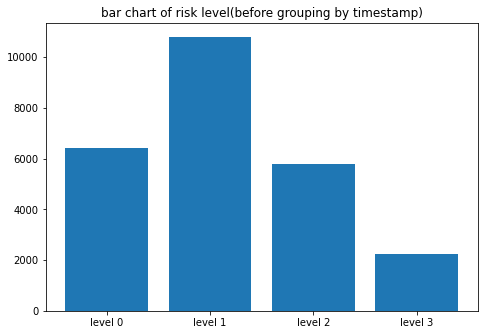

In [26]:
import matplotlib.pyplot as plt
tb=df['Risk-Level'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
levels = ['level 0','level 1','level 2','level 3']
numberofdays = [int(tb[0]),int(tb[1]),int(tb[2]),int(tb[3])]
ax.bar(levels,numberofdays)
ax.set_title('bar chart of risk level(before grouping by timestamp)')
plt.show()

In [27]:
#Data Exploration

#according to risk score boxplot

#risk scores greater than 1000
test1 = df[df['Risk-Score'] > 1000]
#output: HARVARD PARK, WEST VERNON, VERNON CENTRAL, WHOLESALE DISTRICT

#risk scores less than 0
test2 = df[df['Risk-Score'] < -100]
#output: WEST VERNON, VERNON CENTRAL


In [28]:
#drop HARVARD PARK, WEST VERNON, VERNON CENTRAL, WHOLESALE DISTRICT

#hp = df[df['Region'].str.contains("Harvard Park")]
#wv = df[df['Region'].str.contains("West Vernon")]
#vc = df[df['Region'].str.contains("Vernon Central")]
#wd = df[df['Region'].str.contains("Wholesale District")]

#outlier_frames = [hp, wv, vc, wd]
#result = pd.concat(outlier_frames)

#df = pd.concat([df,result, result ]).drop_duplicates(keep=False)


In [29]:
#this definition returns an update dataframe with rolling average, rolling cases, and average cases

def calc_risk_trend(area, length1):
    df_recent_1= pd.DataFrame()
    df_rolling_1= pd.DataFrame()
    df_rolling_cases = pd.DataFrame()
    
    if area == 'LA COUNTY': # if 'all' is given, iterate through all regions in the data
        regions = 'LA COUNTY'
        df_mean = df.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA COUNTY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
        
    elif area == 'LA CITY':
        df_la = df.copy()
        df_la = df_la[df_la['Region'].isin(los_angeles_region)]
        df_mean = df_la.copy()
        df_mean = df_mean.groupby(["Time Stamp"]).mean()
        df_mean=df_mean.drop(['Number of cases','New Cases'], axis=1)
        df_sum = df_la.copy()
        df_sum = df_sum.groupby(["Time Stamp"]).sum()
        df_sum = df_sum[['Number of cases','New Cases']]
        df_new=df_sum.merge(df_mean, left_index=True, right_index=True, how='left')
        df_new['Region']='LA CITY'
        df_new['Time Stamp']=df_new.index
        df_new = df_new.set_index('index')
        
    else:
        df_new=df.copy()
        df_new = df_new[df_new['Region']==area]
    
    df_region = df_new.sort_values('Time Stamp')
    
    # defining specific dates that we are going to pull data from
    recent_date = max(df_region['Time Stamp'])
    length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
    
    # pulling data matching dates defined
    df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
    df_recent = df_region[df_region['Time Stamp']==recent_date]
    
    # calculating rolling averages
    rolling_rs_1 = df_region['Risk-Score'].rolling(length1, min_periods=1).mean()
    rolling_cases = df_region['New Cases'].rolling(length1, min_periods=1).mean()
    
    df_rolling_1 = df_rolling_1.append(rolling_rs_1)
    df_rolling_cases = df_rolling_cases.append(rolling_cases)
    
    df_rolling_1_sum = df_rolling_1.sum(skipna = True, axis=0)
    df_rolling_cases_sum = df_rolling_cases.sum(skipna = True, axis=0)
    

    rolling_1 = pd.DataFrame()
    rolling_c = pd.DataFrame()

    string3 = "Risk Score Rolling Avg"

    rolling_1[string3]=df_rolling_1_sum
    rolling_c['New Cases Rolling Avg']=df_rolling_cases_sum

    df_updated = df_region.merge(rolling_1, left_index=True, right_index=True, how='left')
    df_updated = df_updated.merge(rolling_c, left_index=True, right_index=True, how='left')

    df_updated = df_updated.sort_values('Time Stamp')
    
    return df_updated

In [30]:
df_final = calc_risk_trend('LA COUNTY', 18)
df_final['Risk-Level']=round(df_final['Risk-Level'])
df_final['Risk-Level'].value_counts()

1.0    104
2.0     56
0.0      7
Name: Risk-Level, dtype: int64

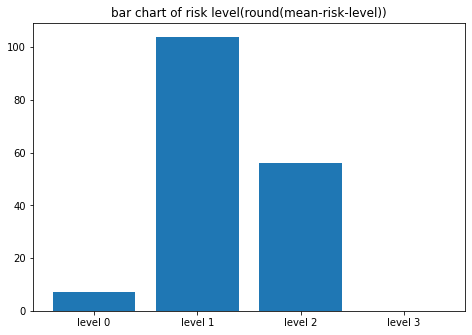

In [31]:
# using round(mean-risk-level)
tb1=df_final['Risk-Level'].value_counts()
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
levels = ['level 0','level 1','level 2','level 3']
numberofdays = [int(tb1[0]),int(tb1[1]),int(tb1[2]),0]
ax.bar(levels,numberofdays)
ax.set_title('bar chart of risk level(round(mean-risk-level))')
plt.show()

In [32]:
df_final = calc_risk_trend('LA COUNTY', 18)
df_final['Risk-Level']=df_final['Risk-Level'].apply(lambda x:int(x))
df_final['Risk-Level'].value_counts()

1    87
0    80
Name: Risk-Level, dtype: int64

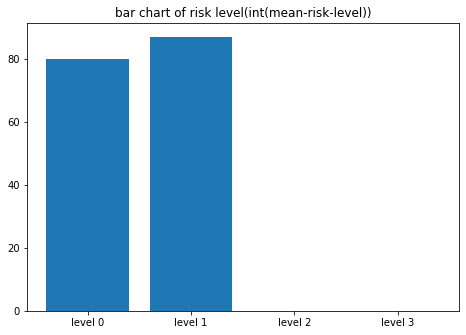

In [33]:
# using int(mean-risk-level)
import matplotlib.pyplot as plt
tb2=df_final['Risk-Level'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
levels = ['level 0','level 1','level 2','level 3']
numberofdays = [int(tb2[0]),int(tb2[1]),0,0]
ax.bar(levels,numberofdays)
ax.set_title('bar chart of risk level(int(mean-risk-level))')
plt.show()

In [34]:
df_final

Number of cases  New Cases  Risk-Level   Risk-Score     Region  \
index                                                                          
13077.838710            142.0        0.0           0   564.936691  LA COUNTY   
12669.769231            247.0       39.0           0   484.250122  LA COUNTY   
13245.952381            320.0       49.0           0   470.689502  LA COUNTY   
13126.089552            502.0       52.0           0   344.526270  LA COUNTY   
13182.155844            768.0      187.0           0   324.812423  LA COUNTY   
13743.910112            834.0       23.0           0   489.136698  LA COUNTY   
13517.284314           1115.0      199.0           0   420.641831  LA COUNTY   
13248.178571           1349.0      188.0           0   417.784484  LA COUNTY   
13285.088000           1649.0      212.0           0   388.243488  LA COUNTY   
13304.302326           1995.0      316.0           0   382.432576  LA COUNTY   
12969.188811           2429.0      308.0           0   357.130948  LA COUNTY   
12715.503497           2778.0      333.0           0   367.148414  LA COUNTY   
12795.979866           3234.0      404.0           0   346.939711  LA COUNTY   
12830.573333           3763.0      521.0           0   339.496896  LA COUNTY   
12791.973510           4291.0      510.0           0   362.405729  LA COUNTY   
12717.743421           4683.0      381.0           0   371.119159  LA COUNTY   
12718.743421           5119.0      436.0           0   379.594857  LA COUNTY   
12712.006536           5515.0      396.0           0   388.947680  LA COUNTY   
12671.425806           5951.0      424.0           0   401.284569  LA COUNTY   
12672.425806           6324.0      373.0           0   401.347887  LA COUNTY   
12601.865385           6714.0      384.0           0   399.516833  LA COUNTY   
12602.865385           6928.0      214.0           0   428.166125  LA COUNTY   
12603.865385           7134.0      206.0           0   444.695298  LA COUNTY   
12604.865385           7573.0      439.0           0   472.874354  LA COUNTY   
12605.865385           7936.0      363.0           0   463.355370  LA COUNTY   
12606.865385           8227.0      291.0           0   501.660435  LA COUNTY   
12607.865385           8662.0      435.0           0   510.234325  LA COUNTY   
12608.865385           9141.0      479.0           0   502.613841  LA COUNTY   
12609.865385           9351.0      210.0           0   546.480433  LA COUNTY   
13287.503401           9491.0      650.0           0   623.642245  LA COUNTY   
13288.503401          10699.0     1208.0           0   640.436698  LA COUNTY   
13289.503401          11694.0      995.0           0   649.968379  LA COUNTY   
13290.503401          12723.0     1029.0           0   672.029939  LA COUNTY   
13221.905405          13427.0      671.0           0   659.845311  LA COUNTY   
13153.140940          14110.0      475.0           0   661.148768  LA COUNTY   
13080.900000          14507.0      293.0           0   733.499077  LA COUNTY   
13081.900000          15252.0      745.0           0   784.950182  LA COUNTY   
13082.900000          15803.0      551.0           0   845.999261  LA COUNTY   
13009.456954          16872.0      972.0           0   870.568980  LA COUNTY   
12935.953947          17665.0      667.0           0   908.267070  LA COUNTY   
12861.437908          18711.0      957.0           0   892.646580  LA COUNTY   
12862.437908          19318.0      607.0           0   903.425922  LA COUNTY   
12863.437908          19318.0        0.0           0   987.541839  LA COUNTY   
12864.437908          20312.0      994.0           0   984.075821  LA COUNTY   
12786.337662          21710.0     1352.0           0  1058.416798  LA COUNTY   
12707.122581          22471.0      659.0           0  1058.179876  LA COUNTY   
12627.865385          23177.0      675.0           0  1113.330631  LA COUNTY   
12628.865385          23717.0      540.0           0  1089.188349  LA COUNTY   
12629.865385  

In [35]:
# this function uses calc_risk_trend function to calculate the rolling average and creates a time-series plot
# this function only works when a specific region is given

def plot_rs(city_name,length1,plot_new_case_or_not):
    
    df_final = calc_risk_trend(city_name, length1)
    # round
    df_final['Risk-Level']=round(df_final['Risk-Level'])
    df_a = df[df['Region']==city_name].sort_values('Time Stamp')
    fig = plt.figure(figsize=(20,10))
    ax_left = fig.add_subplot()
    ax_right = ax_left.twinx()
    
    string3 = "Risk Score Rolling Avg"
    
    if plot_new_case_or_not == 'All':
    
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns3 = ax_right.plot('Time Stamp','New Cases', data =df_final, color='green')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns3+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases'])
        y_max_right = y_max_right + y_max_right/3
    
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    elif plot_new_case_or_not == 'Only Risk Score':
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
 
        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10

        ax_left.set_ylim(0, y_max)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    else:
        
        lns1 = ax_left.plot('Time Stamp','Risk-Score', data =df_final, color='black')
        lns2 = ax_left.plot('Time Stamp',string3, data =df_final, color='red')
        lns4 = ax_right.plot('Time Stamp','New Cases Rolling Avg', data =df_final, color='blue')

        lns = lns1+lns2+lns4
        labs = [l.get_label() for l in lns]
        ax_left.legend(lns, labs, loc=2)

        ax_left.grid()
        ax_left.set_xlabel("Date",fontsize=15)
        ax_left.set_ylabel("Risk Score",fontsize=15)
        ax_right.set_ylabel("Number of New Cases",fontsize=15)

        df_new_case_drop=df_final.dropna(axis=0,subset=['New Cases'])

        y_max=max(df_final['Risk-Score'])
        y_max=y_max+y_max/10
        y_max_right = max(df_new_case_drop['New Cases Rolling Avg'])
        y_max_right = y_max_right + y_max_right/3
    
        ax_left.set_ylim(0, y_max)
        ax_right.set_ylim(0,y_max_right)
        ax_left.set_title('Risk Score of ' + city_name, fontsize=20)
    
    # ax_left is 'Risk Score'
    risk_score_0_max=df_final[df_final['Risk-Level']==0]['Risk-Score'].max()
    risk_score_0_min=df_final[df_final['Risk-Level']==0]['Risk-Score'].min()
    
    
    risk_score_1_max=df_final[df_final['Risk-Level']==1]['Risk-Score'].max()
    risk_score_1_min=df_final[df_final['Risk-Level']==1]['Risk-Score'].min()
        
    risk_score_2_max=df_final[df_final['Risk-Level']==2]['Risk-Score'].max()
    risk_score_2_min=df_final[df_final['Risk-Level']==2]['Risk-Score'].min()
    
        
    risk_score_3_max=df_final[df_final['Risk-Level']==3]['Risk-Score'].max()
    risk_score_3_min=df_final[df_final['Risk-Level']==3]['Risk-Score'].min()
    
    ax_left.axhspan(0,risk_score_0_max, color='green', alpha=0.1)
    ax_left.axhspan(risk_score_0_max+1,risk_score_1_max, color='blue', alpha=0.1)
    ax_left.axhspan(risk_score_1_max+1,risk_score_2_max, color='yellow', alpha=0.1)
    ax_left.axhspan(risk_score_2_max+1,y_max+10, color='red', alpha=0.1)
    
    x_line_annotation_1 = dt.datetime(2020, 3, 19)
    x_text_annotation_1 = dt.datetime(2020, 3, 16)
    
    x_line_annotation_2 = dt.datetime(2020, 5, 8)
    x_text_annotation_2 = dt.datetime(2020, 5, 5)
    
    x_line_annotation_3 = dt.datetime(2020, 6, 12)
    x_text_annotation_3 = dt.datetime(2020, 6, 9)
    
    x_line_annotation_4 = dt.datetime(2020, 7, 1)
    x_text_annotation_4 = dt.datetime(2020, 6, 28)
    
    ax_left.axvline(x=x_line_annotation_1, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_1, y=y_max-y_max/4,fontsize=15, s='Stage 1', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_2, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_2, y=y_max-y_max/5,fontsize=15, s='Stage 2', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_3, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_3, y=y_max-y_max/5,fontsize=15, s='Stage 3', alpha=1, color='#334f8d',rotation='vertical')
    ax_left.axvline(x=x_line_annotation_4, linestyle='dashed', alpha=1)
    ax_left.text(x=x_text_annotation_4, y=y_max-y_max/5,fontsize=15, s='Reclosure', alpha=1, color='#334f8d',rotation='vertical')
    
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


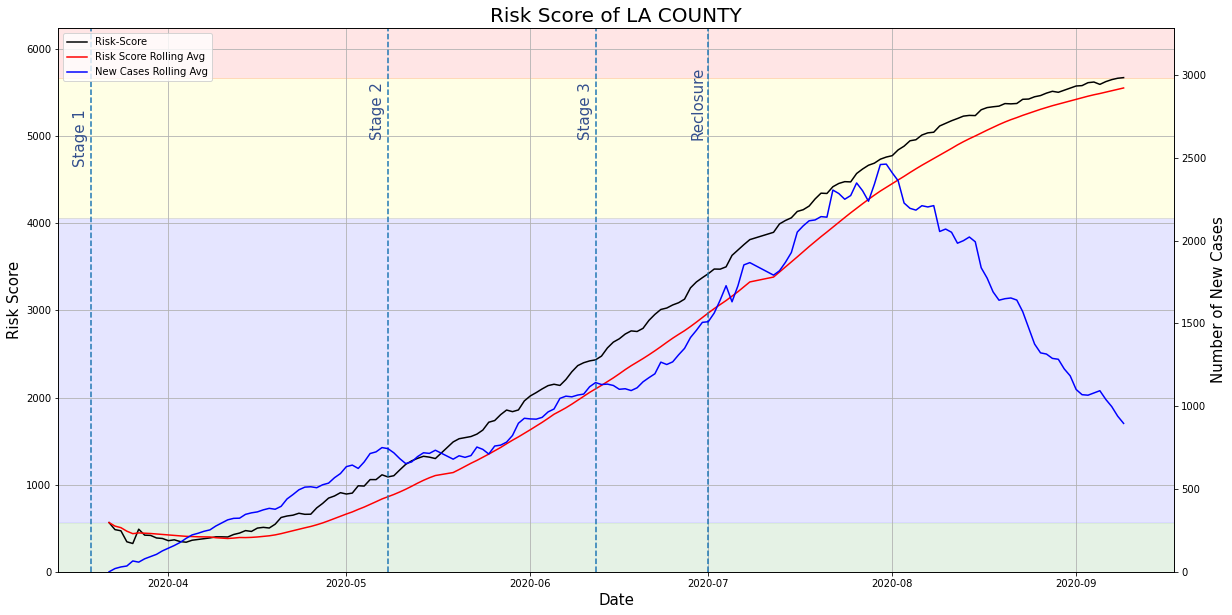

In [36]:
#PRE-DROPPED OUTLIERS LA COUNTY
plot_rs('LA COUNTY', 18, '')

In [37]:
#drop HARVARD PARK, WEST VERNON, VERNON CENTRAL, WHOLESALE DISTRICT

hp = df[df['Region'].str.contains("Harvard Park")]
wv = df[df['Region'].str.contains("West Vernon")]
vc = df[df['Region'].str.contains("Vernon Central")]
wd = df[df['Region'].str.contains("Wholesale District")]

outlier_frames = [hp, wv, vc, wd]
result = pd.concat(outlier_frames)

df = pd.concat([df,result, result ]).drop_duplicates(keep=False)

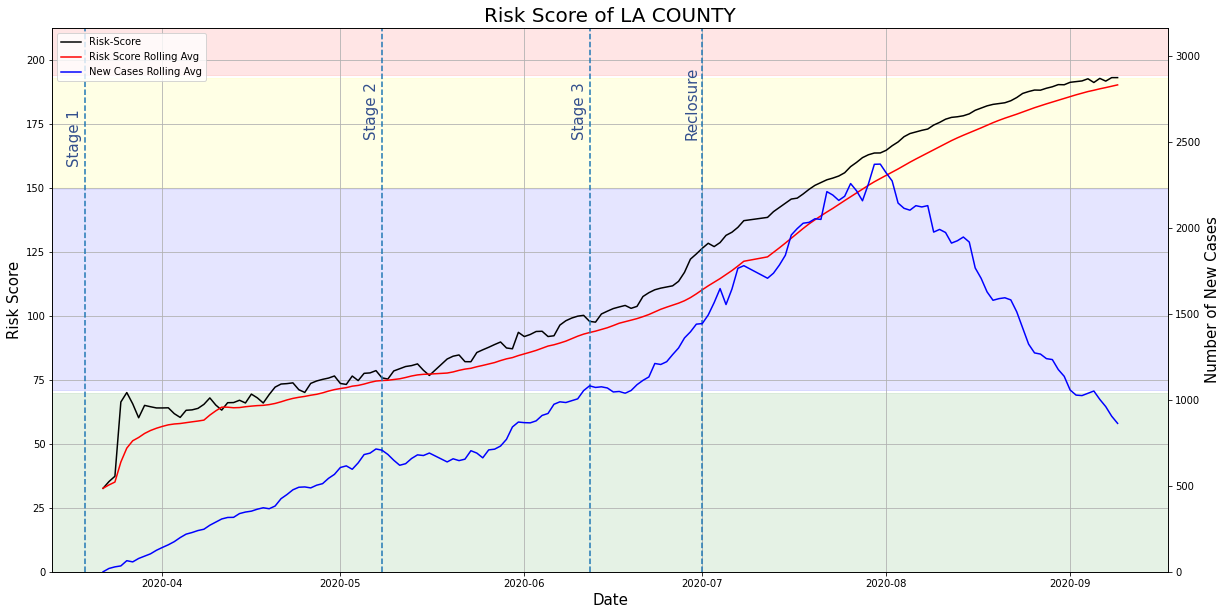

In [38]:
#POST-DROPPED OUTLIERS LA COUNTY
plot_rs('LA COUNTY', 18, '')

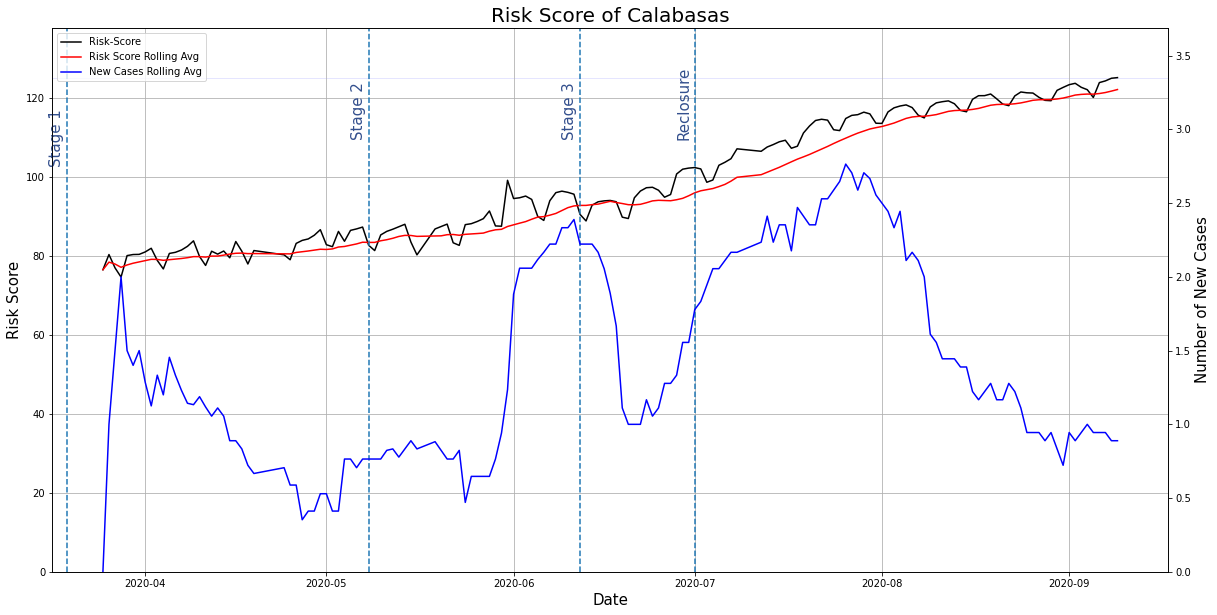

In [43]:
plot_rs('Calabasas', 18, '')

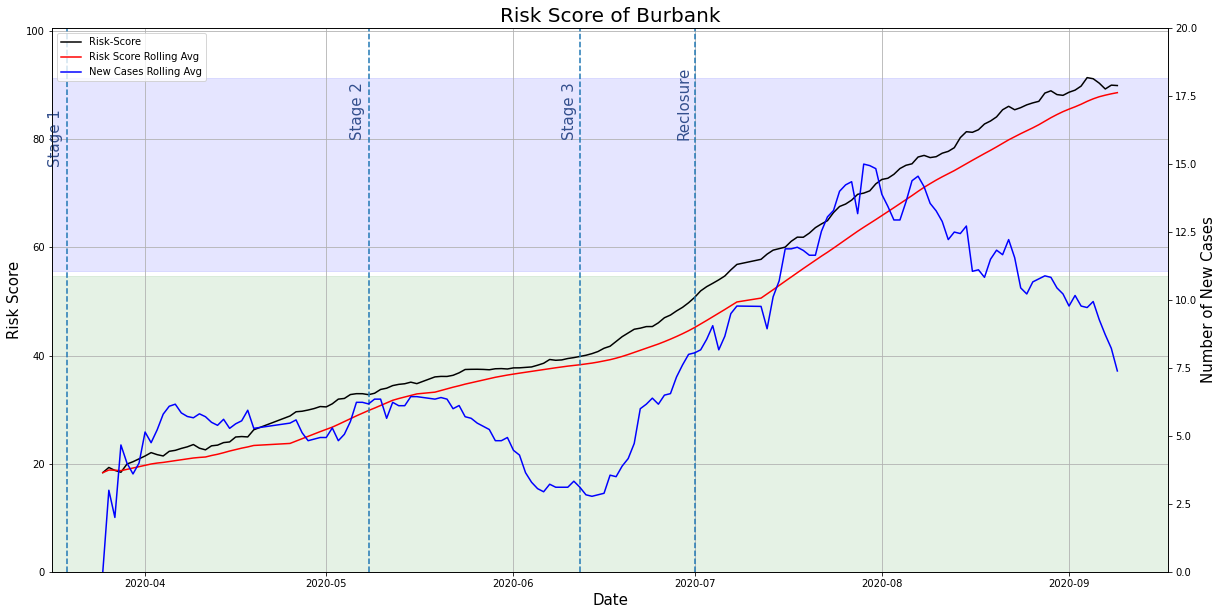

In [44]:
plot_rs('Burbank', 18, '')

In [28]:
#Calabasas data exploration
df[df['Region'].str.contains("Calabasas")]

index     Region  Predicted new cases  Risk-Level  Risk-Score  \
2826   2923  Calabasas            144.21579           1   62.350104   
2827   2924  Calabasas            153.52243           1   66.373727   
2828   2925  Calabasas            151.77563           1   65.618519   
2829   2926  Calabasas            152.58212           1   65.967195   
2830   2927  Calabasas            158.09781           1   68.351841   
2831   2928  Calabasas            159.05655           1   68.766342   
2832   2929  Calabasas            159.00537           1   68.744216   
2833   2930  Calabasas            159.96735           1   69.160115   
2834   2931  Calabasas            161.63540           1   69.881283   
2835   2932  Calabasas            154.01175           1   66.585279   
2836   2933  Calabasas            154.51636           1   66.803440   
2837   2934  Calabasas            161.78781           1   69.947173   
2838   2935  Calabasas            159.54565           1   68.977801   
2839   2936  Calabasas            160.34665           1   69.324103   
2840   2937  Calabasas            161.16882           1   69.679560   
2841   2938  Calabasas            162.73462           1   70.356515   
2842   2939  Calabasas            156.43674           1   67.633695   
2843   2940  Calabasas            155.38248           1   67.177897   
2844   2941  Calabasas            158.71744           1   68.619731   
2845   2942  Calabasas            158.46548           1   68.510802   
2846   2943  Calabasas            160.78100           1   69.511892   
2847   2944  Calabasas            153.08188           1   66.183259   
2848   2945  Calabasas            161.78790           1   69.947213   
2849   2946  Calabasas            159.49884           1   68.957562   
2850   2947  Calabasas            156.92456           1   67.844600   
2851   2948  Calabasas            162.30334           1   70.170058   
2852   2953  Calabasas            159.96075           1   69.157265   
2853   2954  Calabasas            160.23718           1   69.276776   
2854   2955  Calabasas            166.86932           1   72.144109   
2855   2956  Calabasas            168.56857           1   72.878760   
2856   2957  Calabasas            169.36432           1   73.222792   
2857   2958  Calabasas            170.29825           1   73.626566   
2858   2959  Calabasas            171.41656           1   74.110058   
2859   2960  Calabasas            166.72833           1   72.083153   
2860   2961  Calabasas            169.38931           1   73.233598   
2861   2962  Calabasas            175.36179           1   75.815731   
2862   2963  Calabasas            173.51400           1   75.016864   
2863   2964  Calabasas            175.95245           1   76.071100   
2864   2965  Calabasas            175.71402           1   75.968015   
2865   2966  Calabasas            175.69156           1   75.958305   
2866   2967  Calabasas            168.29398           1   72.760041   
2867   2968  Calabasas            170.10342           1   73.542336   
2868   2969  Calabasas            174.56882           1   75.472900   
2869   2970  Calabasas            175.52164           1   75.884841   
2870   2971  Calabasas            176.82840           1   76.449805   
2871   2972  Calabasas            177.78613           1   76.863871   
2872   2973  Calabasas            179.19693           1   77.473813   
2873   2974  Calabasas            172.67856           1   74.655667   
2874   2975  Calabasas            169.68704           1   73.362318   
2875   2976  Calabasas            179.17892           1   77.466029   
2876   2977  Calabasas            179.95440           1   77.801300   
2877   2978  Calabasas            180.94656           1   78.230248   
2878   2979  Calabasas            176.37524           1   76.253889   
2879   2980  Calabasas            178.59875           1   77.215199   
2880   2981  Calabasas            181.79681           1   78.597844   
2881   2982  Calabasas        

In [29]:
# This function calculates trend of the Risk-Score at the most current data.
# Input:  length1, length2:    these parameters define the windows Risk Score differences
#         rolling_length:      window of the rolling average calculation
#         rolling_diff_length: window used to calculate the rolling average difference
# Output: recent:             this new dataframe contains list of all regions with calculated Risk Score Trends on the most current data

def rs_trend_summary(length1,length2,rolling_length,rolling_diff_length,rs_or_case):
    
    #intializing variables
    recent = pd.DataFrame()
    df_recent_1= pd.DataFrame()
    df_recent_2= pd.DataFrame()
    recent
    
    df_new=df.copy()
    regions = df_new['Region'].unique()
#     recent['Region']=regions
#     recent['Date']=recent['Region']
    
    
    for region in regions:
        df_region = df_new[df_new['Region']==region].sort_values('Time Stamp')
        
        recent_date = max(df_region['Time Stamp'])
#         recent.loc[recent['Region']=='Alhambra','Date'] = recent_date
        
#         length1_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length1)
#         length2_bef = pd.to_datetime(recent_date) - dt.timedelta(days=length2)

#         df_1_before = df_region[df_region['Time Stamp'] == length1_bef]
#         df_2_before = df_region[df_region['Time Stamp'] == length2_bef]
        df_recent = df_region[df_region['Time Stamp']==recent_date]
        
        
        
        #Rolling Avreage
        if rs_or_case == 'rs':
            rolling_rs = df_region['Risk-Score'].rolling(rolling_length, min_periods=1).mean()

            recent_rolling_rs = rolling_rs.iloc[-1]

            length3 = 0 - rolling_diff_length -1

            past_rolling_rs = rolling_rs.iloc[length3]

            rolling_diff_rs = recent_rolling_rs - past_rolling_rs



            df_recent["Current_Rolling_Average"] = recent_rolling_rs
            df_recent["Past_Rolling_Average"] = past_rolling_rs
            df_recent["Rolling AVG Change"] = rolling_diff_rs
        

            threshhold=1/7

            if rolling_diff_rs > threshhold:
                df_recent['Trend (Abs)'] = 'UP'
            if (rolling_diff_rs < threshhold) & (rolling_diff_rs > -threshhold):
                df_recent['Trend (Abs)'] = '-'
            if rolling_diff_rs < -threshhold:
                df_recent['Trend (Abs)'] = 'DOWN'

            percent_change = (rolling_diff_rs)*100/past_rolling_rs
            percent_threshhold = 5
            df_recent['Percent Change']=round(percent_change)

            if percent_change > percent_threshhold:
                df_recent['Trend (%)'] = 'UP'
            if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
                df_recent['Trend (%)'] = '-'
            if percent_change < -percent_threshhold:
                df_recent['Trend (%)'] = 'DOWN'
        
#         if rolling_diff > threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Red'
#         if (rolling_diff < threshhold) & (rolling_diff > -threshhold):
#             df_recent['Risk_Trend_Abs'] = 'Yellow'
#         if rolling_diff < -threshhold:
#             df_recent['Risk_Trend_Abs'] = 'Grenn'




        elif rs_or_case == 'case':
            rolling_case = df_region['New Cases'].rolling(rolling_length, min_periods=1).mean()
            recent_rolling_case = rolling_case.iloc[-1]
            length3 = 0 - rolling_diff_length -1
            past_rolling_case = rolling_case.iloc[length3]
            rolling_diff_case = recent_rolling_case - past_rolling_case

            df_recent["Current_Rolling_Average"] = recent_rolling_case
            df_recent["Past_Rolling_Average"] = past_rolling_case
            df_recent["Rolling AVG Change"] = round(rolling_diff_case,5)
            
            threshhold= 3

            if rolling_diff_case > threshhold:
                df_recent['Trend (Abs)'] = 'UP'
            if (rolling_diff_case < threshhold) & (rolling_diff_case > -threshhold):
                df_recent['Trend (Abs)'] = '-'
            if rolling_diff_case < -threshhold:
                df_recent['Trend (Abs)'] = 'DOWN'

            percent_change = (rolling_diff_case)*100/past_rolling_case
            percent_threshhold = 5
            df_recent['Percent Change']=round(percent_change)

            if percent_change > percent_threshhold:
                df_recent['Trend (%)'] = 'UP'
            if (percent_change < percent_threshhold) & (percent_change > -percent_threshhold):
                df_recent['Trend (%)'] = '-'
            if percent_change < -percent_threshhold:
                df_recent['Trend (%)'] = 'DOWN'
        
            
            
            
        
        recent = recent.append(df_recent).sort_values('Time Stamp')
    recent["Rank"] = recent["Rolling AVG Change"].rank()
    recent["Rank"] = recent["Rank"].astype(int)
    recent = recent.sort_values('Rank')
#         recent= recent.rename(columns={"A": "a", "B": "c"})
#         recent=recent.drop(['index','Time Stamp','Latitude', 'Longitude','RS_change_3_Days','RS_change_14_Days'], axis=1)
    recent = recent[['Time Stamp','Region','Number of cases','Risk-Level','Rank','Rolling AVG Change','Trend (Abs)','Percent Change','Trend (%)']]
    return recent

In [30]:
recent = rs_trend_summary(12,13,18,1,'rs')

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\hp\pycharmprojects\test1\venv\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [31]:
recent

Time Stamp                Region  Number of cases  Risk-Level  Rank  \
15745 2020-09-07          Park La Brea             96.0           0     1   
3626  2020-09-07               Castaic           1912.0           3     2   
5215  2020-09-07           Culver City            602.0           1     3   
21676 2020-09-07                Venice            267.0           1     4   
16857 2020-09-07         Redondo Beach            525.0           1     5   
3299  2020-09-07        Canyon Country            259.0           1     6   
24577 2020-09-07       Wilshire Center           1054.0           0     7   
19737 2020-09-07           Studio City            230.0           1     8   
5540  2020-09-07           Diamond Bar            510.0           1     9   
16696 2020-09-07   Rancho Palos Verdes            274.0           1    10   
740   2020-09-07               Arcadia            454.0           1    11   
15268 2020-09-07                 Palms            513.0           1    12   
22321 2020-09-07                Walnut            249.0           1    13   
6337  2020-09-07        East Hollywood            578.0           1    14   
21349 2020-09-07           Valley Glen            564.0           1    15   
20707 2020-09-07              Torrance           1336.0           1    16   
6661  2020-09-07             Echo Park            221.0           1    17   
428   2020-09-07              Alhambra           1175.0           1    18   
12546 2020-09-07             Los Feliz            189.0           1    19   
2504  2020-09-07         Boyle Heights           4068.0           2    20   
23622 2020-09-07              Westlake           2293.0           2    21   
5375  2020-09-07               Del Rey            330.0           1    22   
13039 2020-09-07             Mar Vista            298.0           1    23   
11914 2020-09-07              Lawndale            733.0           2    24   
19252 2020-09-07        South Pasadena            255.0           1    25   
4101  2020-09-07              Cerritos            549.0           1    26   
2668  2020-09-07             Brentwood            270.0           1    27   
10479 2020-09-07             Koreatown           1098.0           1    28   
2983  2020-09-07             Calabasas            241.0           2    29   
23784 2020-09-07              Westwood            333.0           1    30   
3464  2020-09-07                Carson           2213.0           1    31   
17972 2020-09-07             San Pedro           1949.0           2    32   
7291  2020-09-07                Encino            521.0           1    33   
20542 2020-09-07           Temple City            500.0           2    34   
18629 2020-09-07            Silverlake            593.0           2    35   
15905 2020-09-07              Pasadena           2844.0           1    36   
10804 2020-09-07             La Mirada            894.0           2    37   
10320 2020-09-07             Inglewood           2708.0           2    38   
6973  2020-09-07            El Segundo            311.0           2    39   
18301 2020-09-07          Santa Monica            816.0           1    40   
2177  2020-09-07         Beverly Hills            625.0           2    41   
14793 2020-09-07               Norwalk           3061.0           2    42   
9518  2020-09-07         Highland Park           1032.0           2    43   
12387 2020-09-07                Lomita            242.0           2    44   
22967 2020-09-07            West Hills            521.0           1    45   
11120 2020-09-07              La Verne            459.0           1    46   
12875 2020-09-07       Manhattan Beach            330.0           1    47   
23132 2020-09-07        West Hollywood            512.0           1    48   
279   2020-09-07          Agoura Hills            153.0           1    49   
7126  2020-09-07             El Sereno           1152.0           2    50   
4410  2020-09-07             Claremont            378.0           1    51   
24